## 데이터 전처리
> 데이터의 특성을 이해, 데이터의 수정 -> `데이터의 품질 향상`

1. 데이터 분석 (EDA)
    - 데이터가 어떤 의미를 가지는지 분석 
    - 다양한 가설 검정
    - 데이터의 이상유무 체크
    - 시각화를 통한 인사이트 생성

2. 결측치 처리

3. 이상치 처리

4. 연속형 변수 처리

5. 범주형 변수 처리

6. 파생 변수 생성 (Feature Engineering)

7. 변수 선택

### 데이터셋 개요

In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/Users/mangoo/Library/Fonts/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

# import eli5
# from eli5.sklearn import PermutationImportance

In [2]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '../../data/train.csv'
test_path  = '../../data/test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

# # 추가 데이터 load
# bus_feature = pd.read_csv('./data/bus_feature.csv')
# subway_feature = pd.read_csv('./data/subway_feature.csv')

In [3]:
# Train data와 Test data shape은 아래와 같습니다.
print('Train data shape : ', dt.shape, 'Test data shape : ', dt_test.shape)
# print('Bus feature data shape : ', bus_feature.shape, 'Subway feature data shape : ', subway_feature.shape)

Train data shape :  (1118822, 52) Test data shape :  (9272, 51)


In [4]:
# Train과 Test data를 살펴보겠습니다.
display(dt.head(1))
display(dt_test.head(1))      # 부동산 실거래가(=Target) column이 제외된 모습입니다.
# display(bus_feature.head(1))
# display(subway_feature.head(1))

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,202307,26,5,1987,...,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0


In [5]:
dt.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target'],
      dtype='object')

- `시군구`: **구**에 따라 가격이 차이가 심할듯 (더하여 **동**도 고려할 필요가 있다)
- `번지`: `본번` + `부번` 으로 이루어진 데이터로 `본번`의 경우 **동**과 유사할 수 있다. 
- `아파트명`
- `전용면적`: 소유자가 독점하여 사용하는 면적 (평수)

> 전용 면적을 제외하고 아래 면적과 관련된 놈들은 약 24만개 왔다갔다함 - 어떻게 채워넣을 방법없나?
> - 데이터가 잘 채워져있는 아파트명으로 구분해본 결과 아파트명이 같아도 그 아파트 전체 면적관련 데이터가 null 임
- `연면적`, `주거전용면적`, `관리비부과면적`: 거의 비슷한 관계
- `건축면적`: 건축물의 외벽 선을 따라 구한 면적 -> 건축면적이 연면적(주거전용면적) 등보다 작다는 것은 같은 아파트의 여러 '동'이 존재하는 것
- `전체동수`, `전체세대수`: 전용면적과 전체세대수를 곱하면 주거전용면적과 유사함.
- `주차대수`: 넓으면 많겠지 - 약한놈
- `'k-전용면적별세대현황(60㎡이하)','k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과'`

    

## EDA

- 숫자형 변수 통계치 확인해보기
- 의미있는 변수에 대해서 시각화해보기
- 결측치와 이상치확인해보기
- 결측치가 있다면 결측치가 왜 생겼을지 고민해보기

In [18]:
dt.iloc[:, :22].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118822 entries, 0 to 1118821
Data columns (total 22 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   시군구                 1118822 non-null  object 
 1   번지                  1118597 non-null  object 
 2   본번                  1118747 non-null  float64
 3   부번                  1118747 non-null  float64
 4   아파트명                1116696 non-null  object 
 5   전용면적(㎡)             1118822 non-null  float64
 6   계약년월                1118822 non-null  int64  
 7   계약일                 1118822 non-null  int64  
 8   층                   1118822 non-null  int64  
 9   건축년도                1118822 non-null  int64  
 10  도로명                 1118822 non-null  object 
 11  해제사유발생일             5983 non-null     float64
 12  등기신청일자              1118822 non-null  object 
 13  거래유형                1118822 non-null  object 
 14  중개사소재지              1118822 non-null  object 
 15  k-단지분류(아파트,주상복합

In [19]:
dt.iloc[:, 22:].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118822 entries, 0 to 1118821
Data columns (total 32 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   k-난방방식                  249259 non-null   object 
 1   k-전체동수                  248192 non-null   float64
 2   k-전체세대수                 249259 non-null   float64
 3   k-건설사(시공사)              247764 non-null   object 
 4   k-시행사                   247568 non-null   object 
 5   k-사용검사일-사용승인일           249126 non-null   object 
 6   k-연면적                   249259 non-null   float64
 7   k-주거전용면적                249214 non-null   float64
 8   k-관리비부과면적               249259 non-null   float64
 9   k-전용면적별세대현황(60㎡이하)      249214 non-null   float64
 10  k-전용면적별세대현황(60㎡~85㎡이하)  249214 non-null   float64
 11  k-85㎡~135㎡이하            249214 non-null   float64
 12  k-135㎡초과                327 non-null      float64
 13  k-홈페이지                  113175 non-null   object 
 14  k-

In [9]:
dt.describe().T

,count,mean,std,min,25%,50%,75%,max
본번,1118747.0,5.649108e+02,5.160642e+02,0.000000e+00,1.760000e+02,4.700000e+02,7.810000e+02,4.974000e+03
부번,1118747.0,5.978885e+00,4.668584e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.837000e+03
전용면적(㎡),1118822.0,7.717475e+01,2.936423e+01,1.002000e+01,5.965000e+01,8.188000e+01,8.496000e+01,4.243200e+02
계약년월,1118822.0,2.014760e+05,4.187868e+02,2.007010e+05,2.011100e+05,2.015070e+05,2.018040e+05,2.023060e+05
계약일,1118822.0,1.580656e+01,8.721166e+00,1.000000e+00,8.000000e+00,1.600000e+01,2.300000e+01,3.100000e+01
층,1118822.0,8.871968e+00,5.982584e+00,-4.000000e+00,4.000000e+00,8.000000e+00,1.200000e+01,6.900000e+01
건축년도,1118822.0,1.998755e+03,9.333908e+00,1.961000e+03,1.992000e+03,2.000000e+03,2.005000e+03,2.023000e+03
해제사유발생일,5983.0,2.021057e+07,1.060697e+04,2.020022e+07,2.020082e+07,2.021030e+07,2.022021e+07,2.023093e+07
단지소개기존clob,68582.0,5.415300e+02,7.518099e+02,1.000000e+00,4.000000e+00,1.740000e+02,7.250000e+02,2.888000e+03
k-전체동수,248192.0,1.479835e+01,1.769353e+01,1.000000e+00,5.000000e+00,1.000000e+01,1.700000e+01,1.240000e+02


In [6]:
dt['구'] = dt['시군구'].apply(lambda x:x.split()[1])
dt['동'] = dt['시군구'].apply(lambda x:x.split()[2])

In [7]:
면적관련 = dt[['구', '동', '아파트명', '전용면적(㎡)', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적','k-전체세대수', 'k-전체동수', '건축면적']]
면적관련

,구,동,아파트명,전용면적(㎡),k-연면적,k-주거전용면적,k-관리비부과면적,k-전체세대수,k-전체동수,건축면적
0,강남구,개포동,개포6차우성,79.97,22637.0,20204.0,22637.0,270.0,8.0,4858.0
1,강남구,개포동,개포6차우성,79.97,22637.0,20204.0,22637.0,270.0,8.0,4858.0
2,강남구,개포동,개포6차우성,54.98,22637.0,20204.0,22637.0,270.0,8.0,4858.0
3,강남구,개포동,개포6차우성,79.97,22637.0,20204.0,22637.0,270.0,8.0,4858.0
4,강남구,개포동,개포6차우성,79.97,22637.0,20204.0,22637.0,270.0,8.0,4858.0
...,...,...,...,...,...,...,...,...,...,...
1118817,은평구,구산동,갈현현대,59.94,45515.0,28335.0,28335.0,366.0,4.0,0.0
1118818,은평구,구산동,갈현현대,59.94,45515.0,28335.0,28335.0,366.0,4.0,0.0
1118819,은평구,구산동,갈현현대,84.83,45515.0,28335.0,28335.0,366.0,4.0,0.0
1118820,은평구,구산동,갈현현대,84.83,45515.0,28335.0,28335.0,366.0,4.0,0.0


In [9]:
면적관련.groupby('아파트명').all()

,구,동,전용면적(㎡),k-연면적,k-주거전용면적,k-관리비부과면적,k-전체세대수,k-전체동수,건축면적
아파트명,,,,,,,,,
153-25,True,True,True,True,True,True,True,True,True
201호 미공시,True,True,True,True,True,True,True,True,True
2차한양,True,True,True,True,True,True,True,True,True
3RU-City,True,True,True,True,True,True,True,True,True
3차신성미소지움,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...
힐탑트레져1동,True,True,True,True,True,True,True,True,True
힐튼,True,True,True,True,True,True,True,True,True
힐튼빌리지1차,True,True,True,True,True,True,True,True,True


In [26]:
아파트로묶음 = 면적관련.groupby('아파트명')
same = []
all_null = []
diff = []
for name, group in 아파트로묶음:
    if group['k-연면적'].isnull().all():
        all_null.append(name)
    is_area_same = group['k-연면적'].unique().size == 1
    if is_area_same:
        same.append(name)
    else:
        diff.append(name)
    
print(len(same))
print(len(all_null))
print(len(diff))

6483
5802
55


In [27]:
diff

['DMC아이파크',
 '강남한양수자인',
 '강변',
 '강변힐스테이트',
 '경남아너스빌',
 '경향렉스빌',
 '공덕자이',
 '금호베스트빌',
 '대상',
 '대원칸타빌',
 '대주피오레',
 '동부',
 '동아에코빌',
 '동양엔파트',
 '동양파라곤',
 '두산',
 '라이프',
 '래미안그레이튼',
 '롯데캐슬',
 '리첸시아용산',
 '보라매우성',
 '삼익',
 '삼호한숲',
 '상록수',
 '상아2차',
 '서울',
 '서초포레스타3단지',
 '서초포레스타6단지',
 '서희스타힐스',
 '성원',
 '세양청마루',
 '센트라스',
 '신동아',
 '신동아파밀리에',
 '쌍용예가클래식',
 '아남',
 '우리유앤미',
 '천왕연지타운1단지',
 '천왕이펜하우스1단지',
 '천왕이펜하우스2단지',
 '청솔',
 '코오롱하늘채',
 '태흥',
 '포레스트힐시티',
 '한가람',
 '한강',
 '한강타운',
 '한양',
 '한진해모로',
 '한화오벨리스크',
 '해모로',
 '해태보라매타워',
 '현대3',
 '현대성우',
 '효성']

In [24]:
all_null = []
for name, group in 아파트로묶음:
    if group['k-연면적'].isnull().all() and group['k-주거전용면적'].isnull().all() and group['k-관리비부과면적'].isnull().all() and group['k-전체세대수'].isnull().all() and group['k-전체동수'].isnull().all() and group['건축면적'].isnull().all():
        all_null.append(name)
    
print(len(all_null))

5802


In [14]:
면적관련.loc[면적관련['k-주거전용면적'].isnull()]

,구,동,아파트명,전용면적(㎡),k-연면적,k-주거전용면적,k-관리비부과면적,k-전체세대수,k-전체동수,건축면적
975,강남구,개포동,개포주공4단지,50.39,NaN,NaN,NaN,NaN,NaN,NaN
976,강남구,개포동,개포주공4단지,50.39,NaN,NaN,NaN,NaN,NaN,NaN
977,강남구,개포동,개포주공4단지,50.39,NaN,NaN,NaN,NaN,NaN,NaN
978,강남구,개포동,개포주공4단지,42.55,NaN,NaN,NaN,NaN,NaN,NaN
979,강남구,개포동,개포주공4단지,50.39,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1118203,중랑구,중화동,한영,70.96,NaN,NaN,NaN,NaN,NaN,NaN
1118204,중랑구,중화동,현대휴앤미,100.17,NaN,NaN,NaN,NaN,NaN,NaN
1118205,중랑구,중화동,현대휴앤미,95.94,NaN,NaN,NaN,NaN,NaN,NaN
1118206,중랑구,중화동,현대휴앤미,100.20,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
면적관련.loc[면적관련['아파트명'] == '개포6차우성']

,전용면적(㎡),k-연면적,k-주거전용면적,k-관리비부과면적,건축면적,아파트명,동,번지,층
0,79.97,22637.0,20204.0,22637.0,4858.0,개포6차우성,개포동,658-1,3
1,79.97,22637.0,20204.0,22637.0,4858.0,개포6차우성,개포동,658-1,4
2,54.98,22637.0,20204.0,22637.0,4858.0,개포6차우성,개포동,658-1,5
3,79.97,22637.0,20204.0,22637.0,4858.0,개포6차우성,개포동,658-1,4
4,79.97,22637.0,20204.0,22637.0,4858.0,개포6차우성,개포동,658-1,2
...,...,...,...,...,...,...,...,...,...
966324,79.97,22637.0,20204.0,22637.0,4858.0,개포6차우성,개포동,658-1,1
1004784,79.97,22637.0,20204.0,22637.0,4858.0,개포6차우성,개포동,658-1,4
1004785,79.97,22637.0,20204.0,22637.0,4858.0,개포6차우성,개포동,658-1,5
1075994,79.97,22637.0,20204.0,22637.0,4858.0,개포6차우성,개포동,658-1,2


In [50]:
면적관련[면적관련['아파트명'] == '한영']['k-연면적'].value_counts()

Series([], Name: count, dtype: int64)

In [45]:
면적관련.loc[(면적관련['k-연면적'].isnull()) & (면적관련['번지'] == '189')]

,전용면적(㎡),k-연면적,k-주거전용면적,k-관리비부과면적,건축면적,구,동,번지
975,50.39,NaN,NaN,NaN,NaN,강남구,개포동,189
976,50.39,NaN,NaN,NaN,NaN,강남구,개포동,189
977,50.39,NaN,NaN,NaN,NaN,강남구,개포동,189
978,42.55,NaN,NaN,NaN,NaN,강남구,개포동,189
979,50.39,NaN,NaN,NaN,NaN,강남구,개포동,189
...,...,...,...,...,...,...,...,...
1077268,50.67,NaN,NaN,NaN,NaN,강남구,개포동,189
1077269,41.99,NaN,NaN,NaN,NaN,강남구,개포동,189
1077270,41.99,NaN,NaN,NaN,NaN,강남구,개포동,189
1077271,42.55,NaN,NaN,NaN,NaN,강남구,개포동,189


`시군구`
- 서울특별시 데이터이므로 **시** 는 의미없다.
- **동** 단위로 구분하는 경우 데이터 수가 너무 없는 경우가 존재한다.
    - 주요한 **동**을 구반하는 flag 를 두고 기본적으로 **구** 단위로 구분하는 것이 좋아보인다.

In [13]:
dt['시군구'].isnull().sum()

0

In [12]:
dt['구'] = dt['시군구'].apply(lambda x:x.split()[1])
dt['동'] = dt['시군구'].apply(lambda x:x.split()[2])

In [ ]:
# 구에 따른 

## 결측치 및 이상치 처리

`Trash Features`
- 'k-전화번호', 'k-팩스번호', 'k-홈페이지', 'k-관리방식', 'k-시행사', 'k-사용검사일-사용승인일', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '사용허가여부'

`연관성 있어보이는 Features`
- '번지' = '본번' + '부번'
- '계약년월', '계약일'
- '단지신청일' - '단지승인일' ?
- 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', '건축면적'

In [10]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118822 entries, 0 to 1118821
Data columns (total 52 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1118822 non-null  object 
 1   번지                      1118597 non-null  object 
 2   본번                      1118747 non-null  float64
 3   부번                      1118747 non-null  float64
 4   아파트명                    1116696 non-null  object 
 5   전용면적(㎡)                 1118822 non-null  float64
 6   계약년월                    1118822 non-null  int64  
 7   계약일                     1118822 non-null  int64  
 8   층                       1118822 non-null  int64  
 9   건축년도                    1118822 non-null  int64  
 10  도로명                     1118822 non-null  object 
 11  해제사유발생일                 5983 non-null     float64
 12  등기신청일자                  1118822 non-null  object 
 13  거래유형                    1118822 non-null  object 
 14  중개

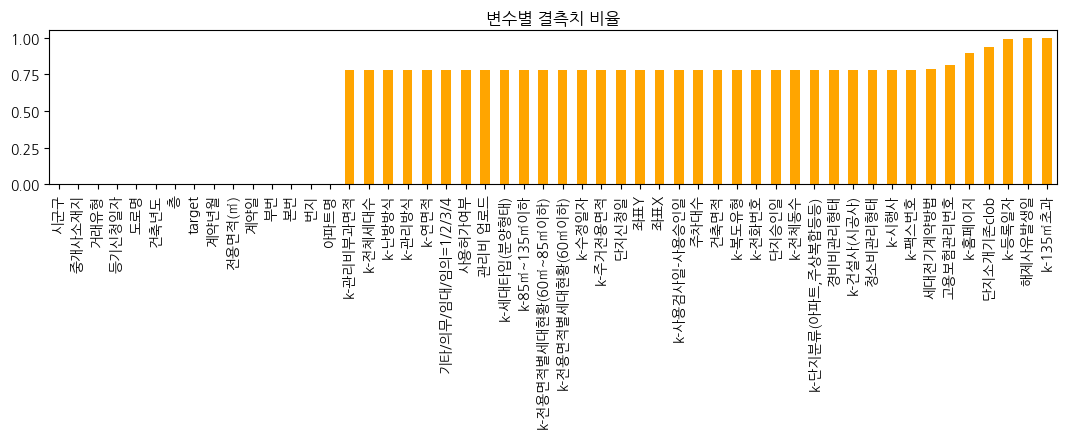

In [11]:
# 변수별 결측치의 비율을 plot으로 그려보면 아래와 같습니다.
fig = plt.figure(figsize=(13, 2))
missing = dt.isnull().sum() / dt.shape[0]
missing = missing[missing > -1]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()